# ARFS - classification

ARFS can be used for classification (binary or multi-class) and for regression. You just have to specify the right loss function.



In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import catboost
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from boruta import BorutaPy as bp
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path

import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.feature_selection import (
    MinRedundancyMaxRelevance,
    GrootCV,
    MissingValueThreshold,
    UniqueValuesThreshold,
    CollinearityThreshold,
    make_fs_summary,
)
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data

plt.style.use("fivethirtyeight")
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 2.0.5


In [3]:
import importlib

importlib.reload(arfs)

<module 'arfs' from '/home/bsatom/Documents/arfs/src/arfs/__init__.py'>

In [4]:
%matplotlib inline

In [5]:
gc.enable()
gc.collect()

4

## Simple Usage
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical) and a genuine but noisy artificial predictor (correlated to the target). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.


In [6]:
# titanic = load_data(name='Titanic')
# X, y = titanic.data, titanic.target

In [7]:
titanic = load_data(name="Titanic")
X, y = titanic.data, titanic.target
y = y.astype(int)

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


## Leshy

In [8]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMClassifier(random_state=42, verbose=-1)
# model = CatBoostClassifier(random_state=42, verbose=0)
# model = XGBClassifier(random_state=42, verbosity=0)

with native (impurity/Gini) importance

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	0
Rejected: 	8
All relevant predictors selected in 00:00:00.55
The selected features: ['age' 'fare']
The agnostic ranking: [3 6 6 4 9 8 1 5 1 2]
The naive ranking: ['fare', 'age', 'random_num', 'pclass', 'random_cat', 'family_size', 'embarked', 'sex', 'title', 'is_alone']


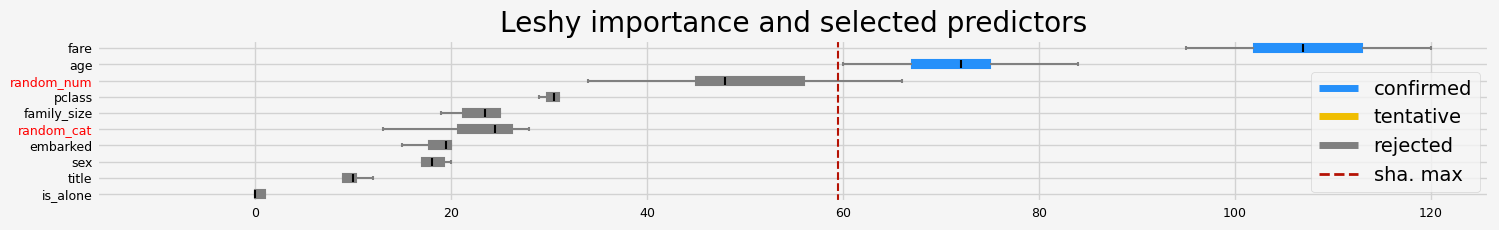

CPU times: user 1.53 s, sys: 160 ms, total: 1.69 s
Wall time: 1.07 s


In [9]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

with SHAP importance, original implementation

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:01.80
The selected features: ['pclass' 'sex' 'age' 'fare']
The agnostic ranking: [1 1 2 4 6 5 1 2 1 3]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'embarked', 'family_size', 'random_num', 'random_cat', 'title', 'is_alone']


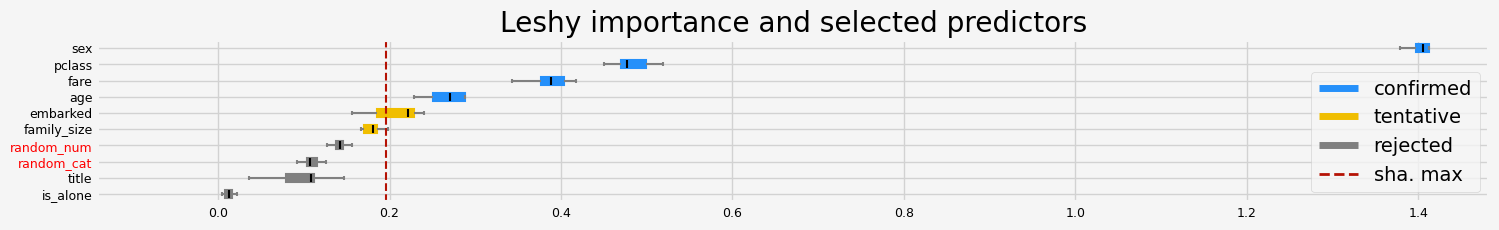

CPU times: user 3.66 s, sys: 246 ms, total: 3.91 s
Wall time: 2.21 s


In [10]:
%%time
# Leshy
model = clone(model)

feat_selector = arfsgroot.Leshy(
    model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

the [LinkedIn fasttreeshap](https://engineering.linkedin.com/blog/2022/fasttreeshap--accelerating-shap-value-computation-for-trees) implementation 

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:01.88
The selected features: ['pclass' 'sex' 'age' 'fare']
The agnostic ranking: [1 1 2 4 6 5 1 2 1 3]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'embarked', 'family_size', 'random_num', 'random_cat', 'title', 'is_alone']


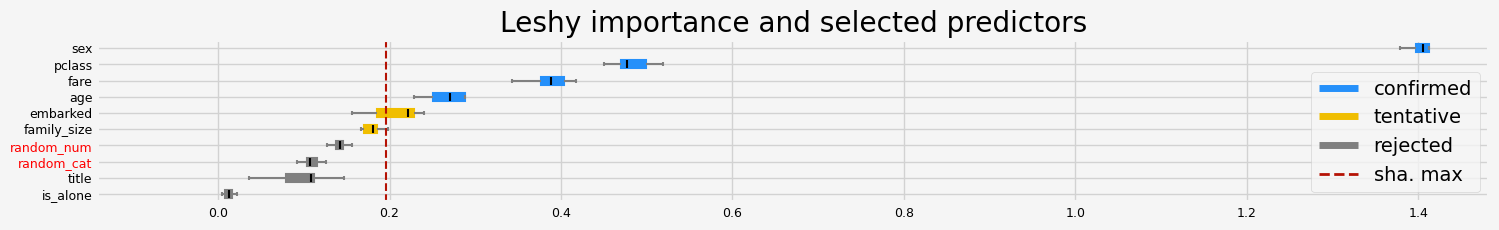

CPU times: user 4.55 s, sys: 227 ms, total: 4.77 s
Wall time: 2.25 s


In [11]:
%%time
# Leshy
model = clone(model)

feat_selector = arfsgroot.Leshy(
    model,
    n_estimators=50,
    verbose=1,
    max_iter=10,
    random_state=42,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

with permutation importance

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:07.64
The selected features: ['pclass' 'sex' 'age' 'family_size']
The agnostic ranking: [1 1 2 6 4 3 1 1 2 5]
The naive ranking: ['sex', 'pclass', 'age', 'family_size', 'fare', 'embarked', 'title', 'is_alone', 'random_num', 'random_cat']


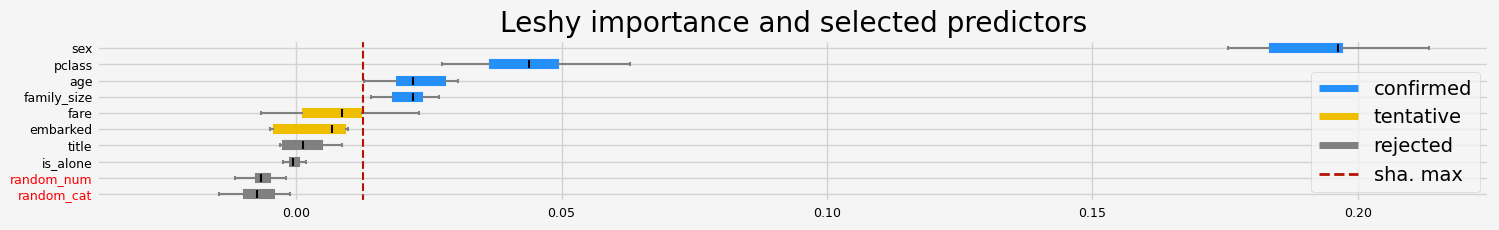

CPU times: user 3.03 s, sys: 442 ms, total: 3.47 s
Wall time: 8.07 s


In [12]:
%%time
# Leshy
model = clone(model)

feat_selector = arfsgroot.Leshy(
    model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance="pimp"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## BoostAGroota

with permutation importance

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['pclass' 'sex' 'age' 'family_size' 'fare']
The agnostic ranking: [2 2 1 1 1 1 2 2 2 1]
The naive ranking: ['sex', 'pclass', 'age', 'family_size', 'fare', 'embarked', 'title', 'is_alone', 'random_cat', 'random_num']


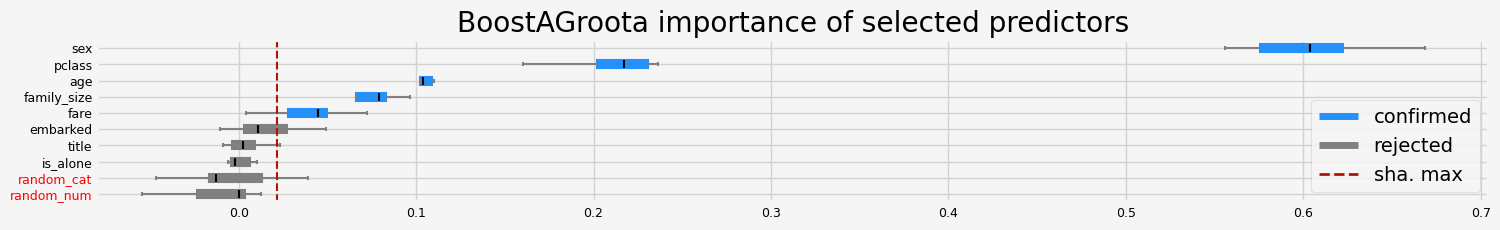

CPU times: user 4.51 s, sys: 394 ms, total: 4.91 s
Wall time: 9.15 s


In [13]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="pimp"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

with SHAP importance

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['pclass' 'sex' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 1 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'embarked', 'family_size', 'random_num', 'random_cat', 'title', 'is_alone']


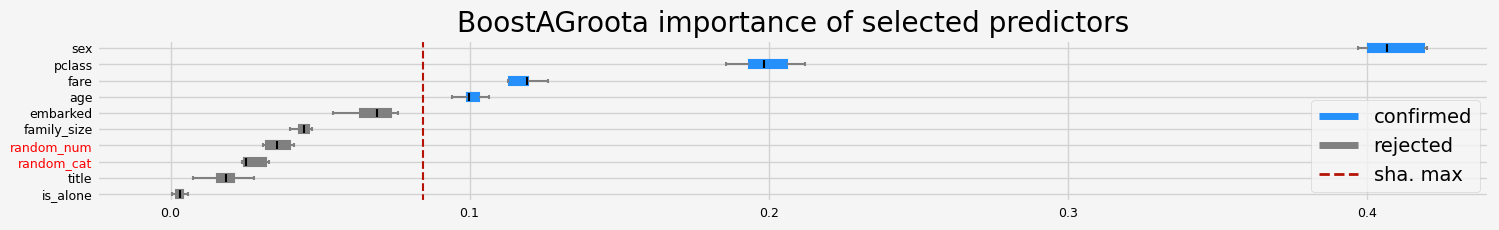

CPU times: user 7.99 s, sys: 339 ms, total: 8.33 s
Wall time: 4.79 s


In [14]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['pclass' 'sex' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 1 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'embarked', 'family_size', 'random_num', 'random_cat', 'title', 'is_alone']


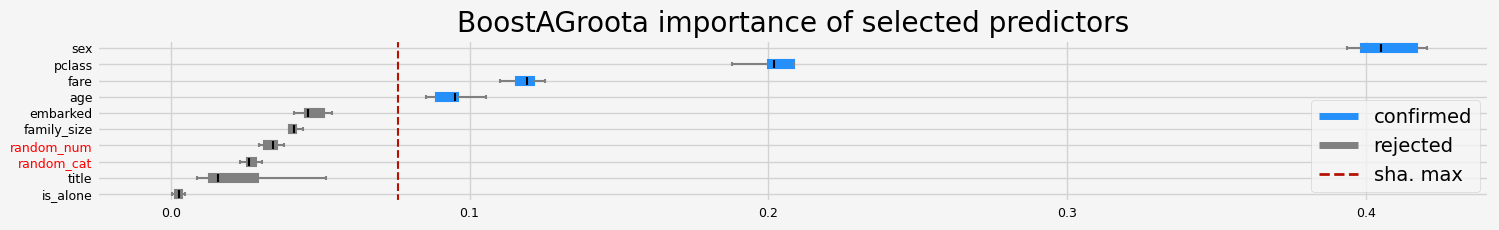

CPU times: user 5.98 s, sys: 348 ms, total: 6.33 s
Wall time: 3.77 s


In [15]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="fastshap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## GrootCV

Internally, it uses lightGBM and SHAP importance (fast and accurate)

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['pclass' 'sex' 'title' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 2 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'title', 'embarked', 'family_size', 'random_num', 'random_cat', 'is_alone']


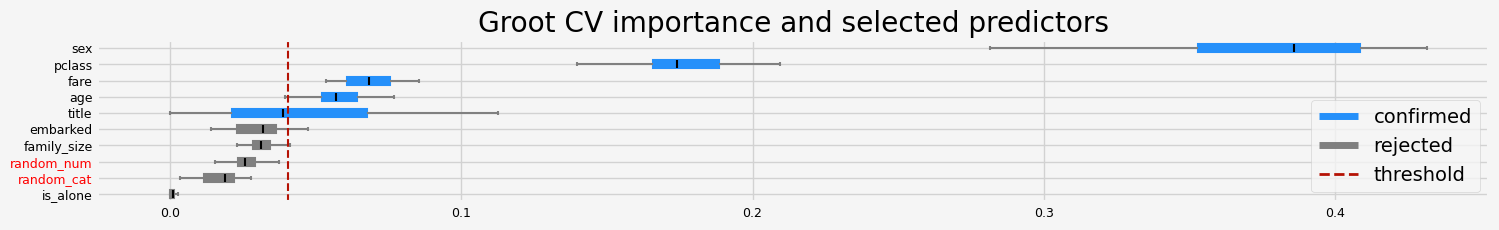

CPU times: user 14.8 s, sys: 1.14 s, total: 16 s
Wall time: 6.57 s


In [16]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="binary", cutoff=1, n_folds=5, n_iter=5, silent=True, fastshap=False
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

For larger datasets, the fasttreshap implementation can speed up the feature selection process. However, for smaller datasets, the overhead might slightly slow down the process.

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['pclass' 'sex' 'title' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 2 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'title', 'embarked', 'family_size', 'random_num', 'random_cat', 'is_alone']


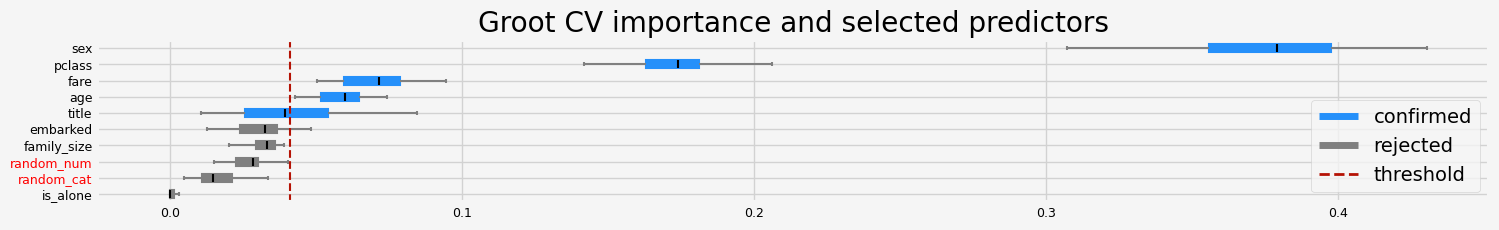

CPU times: user 12.8 s, sys: 1.12 s, total: 13.9 s
Wall time: 6.4 s


In [17]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="binary", cutoff=1, n_folds=5, n_iter=5, silent=True, fastshap=True
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## ARFS in sklearn pipelines

all the selectors (basic, arfs and MRmr) are sklearn compatible and follows the same architecture. Namely, they use the sklearn relevant base classes and therefore have the same methods.

In [18]:
model = clone(model)

# # Leshi/Boruta
# feat_selector = arfsgroot.Leshy(model, n_estimators=50, verbose=1, max_iter=10, random_state=42, importance='shap')

# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="shap"
)

# GrootCV
# feat_selector = arfsgroot.GrootCV(objective='binary', cutoff=1, n_folds=5, n_iter=5, silent=True)

arfs_fs_pipeline = Pipeline(
    [
        ("missing", MissingValueThreshold(threshold=0.05)),
        ("unique", UniqueValuesThreshold(threshold=1)),
        ("collinearity", CollinearityThreshold(threshold=0.85)),
        ("arfs", feat_selector),
    ]
)

X_trans = arfs_fs_pipeline.fit(X=X, y=y).transform(X=X)

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
arfs_fs_pipeline.named_steps["collinearity"].get_feature_names_out()

array(['pclass', 'embarked', 'random_cat', 'is_alone', 'title',
       'random_num'], dtype=object)

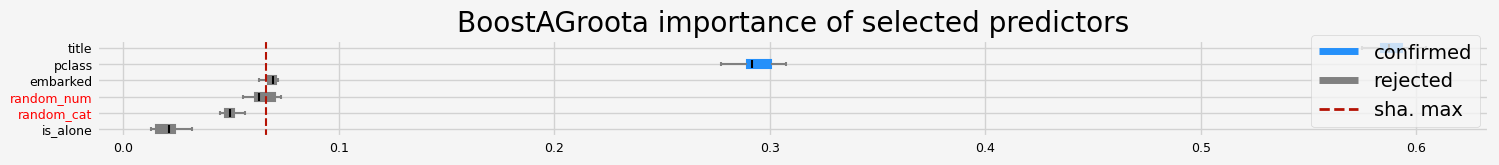

In [20]:
fig = arfs_fs_pipeline.named_steps["arfs"].plot_importance()
# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## Testing and comparing Leshy, GrootCV and BoostAGroota

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.
For Leshy (Boruta) and BoostAGroota, the native feature importance (gini/impurity) returns the less reliable results.

==================== Benchmarking using sklearn permutation importance ====================


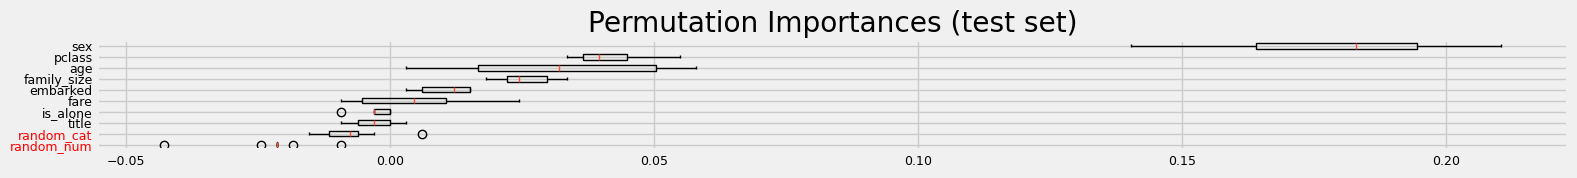

CPU times: user 777 ms, sys: 336 ms, total: 1.11 s
Wall time: 3.1 s


In [21]:
%%time

model = clone(model)
# Benchmark with scikit-learn permutation importance
print("=" * 20 + " Benchmarking using sklearn permutation importance " + "=" * 20)
fig = sklearn_pimp_bench(model, X, y, task="classification", sample_weight=None)

In [22]:
model.__class__.__name__

'LGBMClassifier'

### Testing Leshy

==================== Leshy - testing:    RandomForestClassifier for var.imp: shap            ====================


The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:31.23
['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


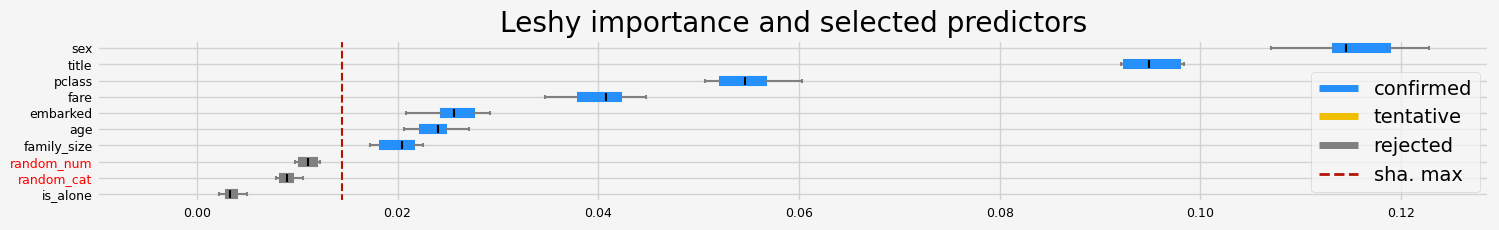

==================== Leshy - testing:    RandomForestClassifier for var.imp: fastshap        ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:11.42
['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


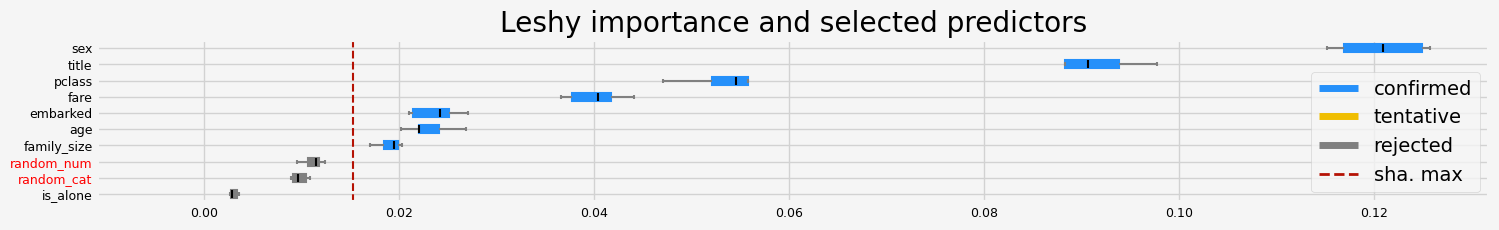

==================== Leshy - testing:    RandomForestClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	1
Rejected: 	4
All relevant predictors selected in 00:00:22.61
['pclass' 'sex' 'title' 'age' 'family_size']


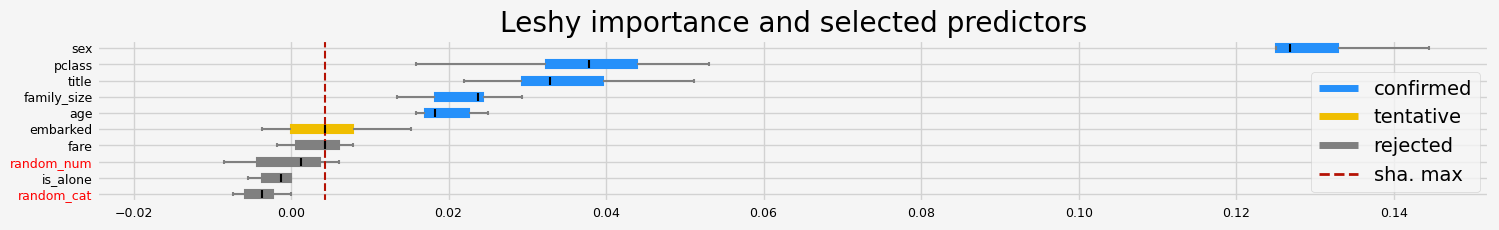

==================== Leshy - testing:    RandomForestClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:04.49
['sex' 'title' 'age' 'fare']


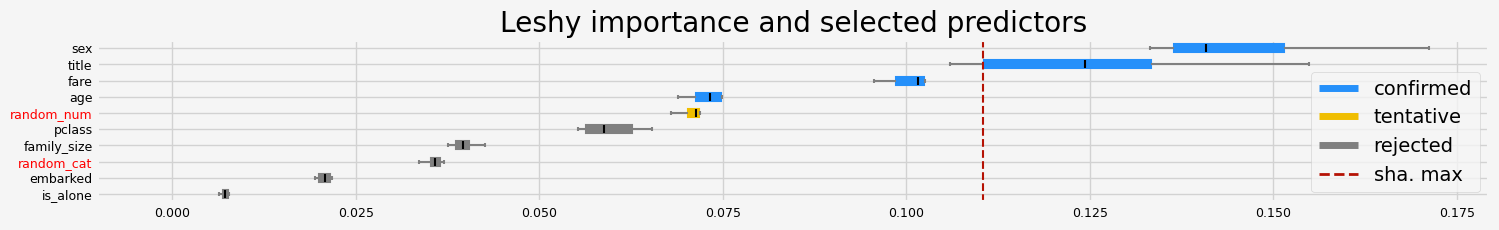

==================== Leshy - testing:        CatBoostClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:05.29
['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


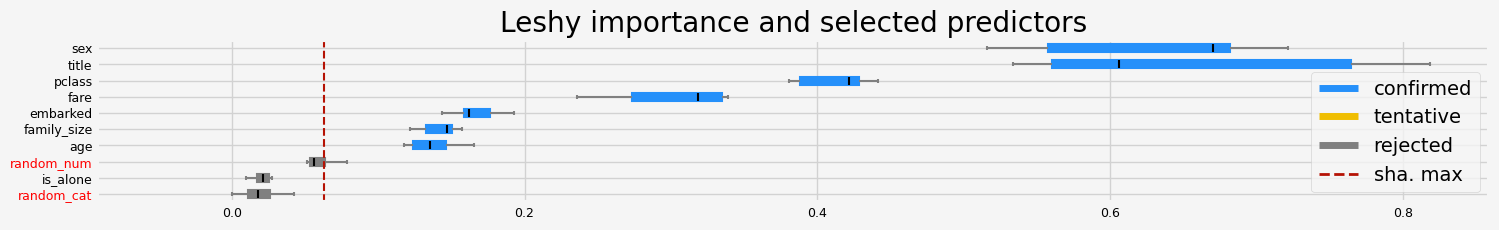

==================== Leshy - testing:        CatBoostClassifier for var.imp: fastshap        ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	6
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:05.04
['pclass' 'sex' 'embarked' 'title' 'family_size' 'fare']


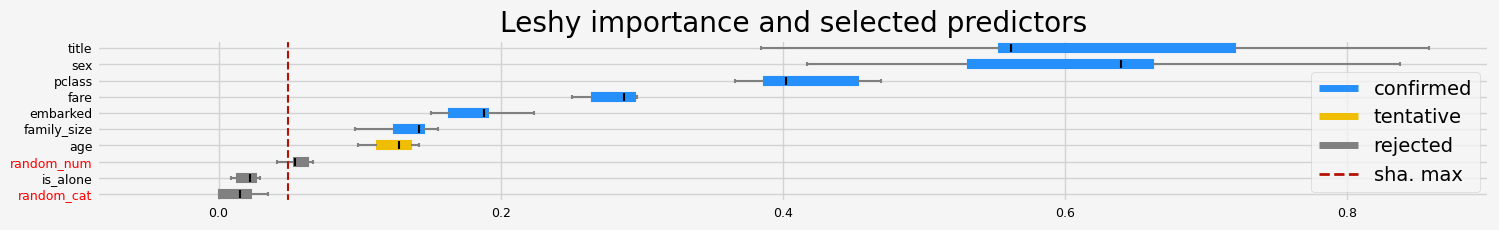

==================== Leshy - testing:        CatBoostClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:07.85
['pclass' 'sex' 'title' 'family_size']


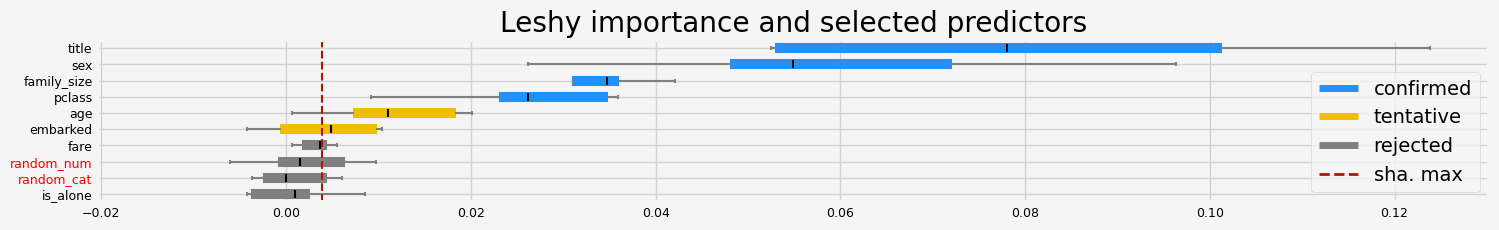

==================== Leshy - testing:        CatBoostClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:04.33
['pclass' 'sex' 'title' 'age' 'fare']


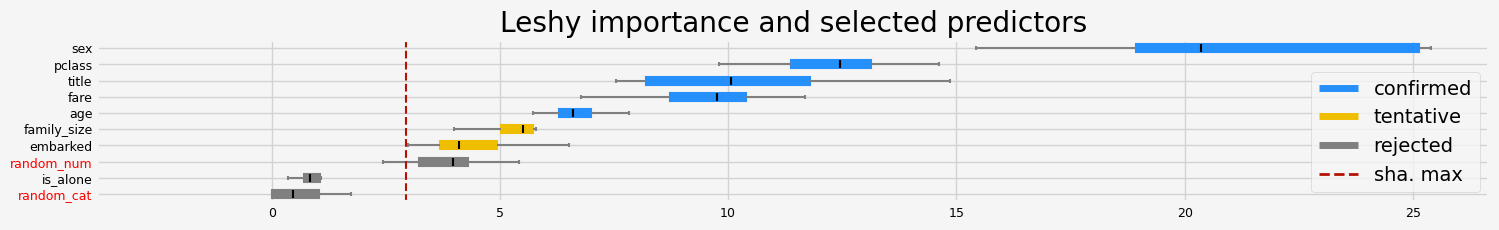

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	0
Rejected: 	6
All relevant predictors selected in 00:00:03.22
['pclass' 'sex' 'age' 'fare']


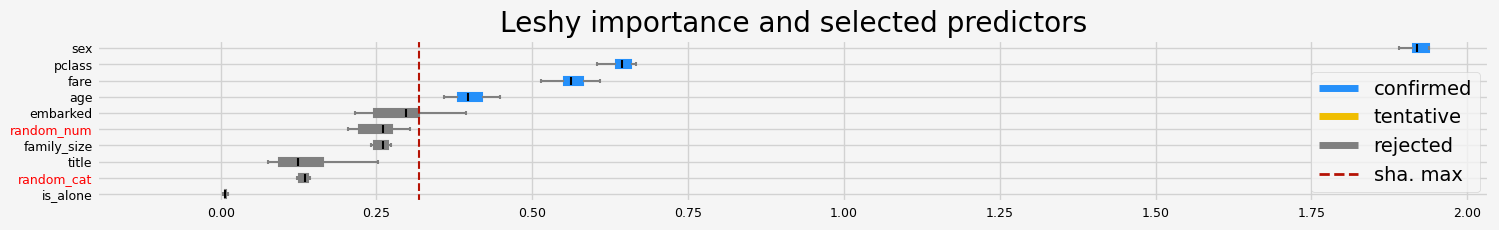

==================== Leshy - testing:            LGBMClassifier for var.imp: fastshap        ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:03.48
['pclass' 'sex' 'age' 'fare']


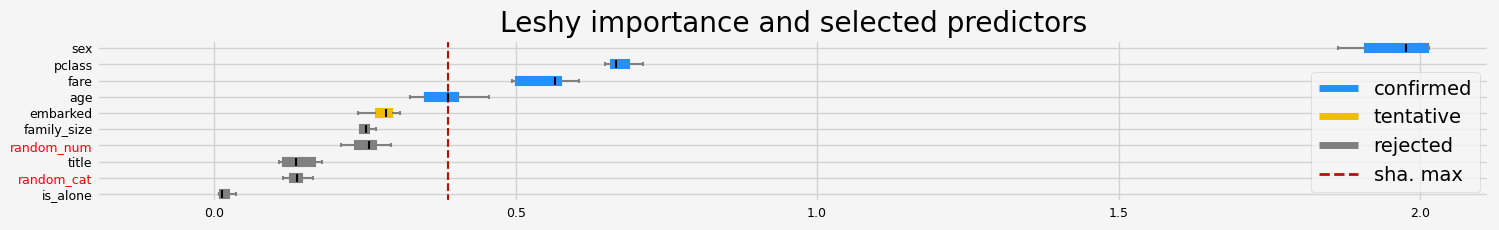

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:07.80
['pclass' 'sex' 'age' 'family_size']


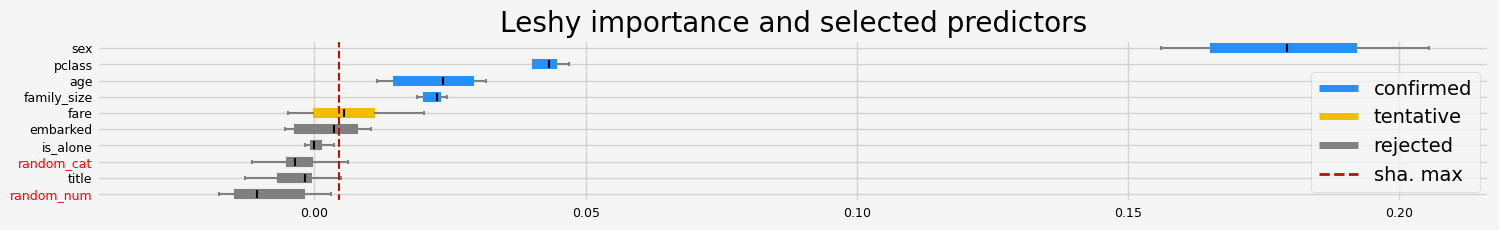

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	1
Tentative: 	1
Rejected: 	8
All relevant predictors selected in 00:00:01.78
['fare']


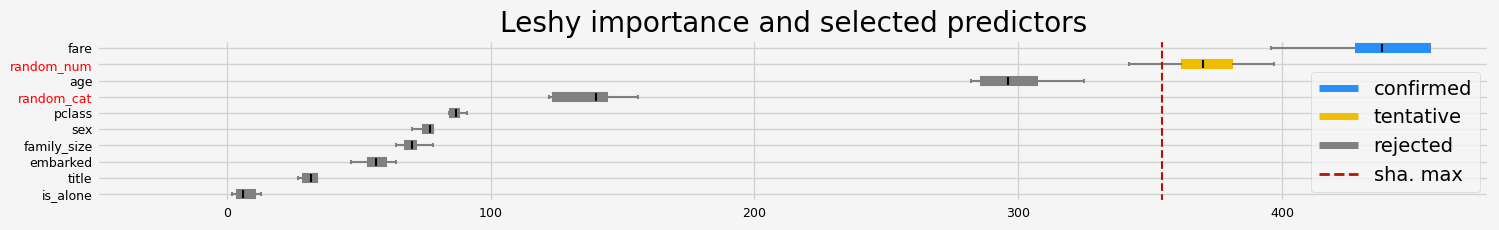

==================== Leshy - testing:            LGBMClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:02.35
['pclass' 'sex' 'embarked' 'title' 'fare']


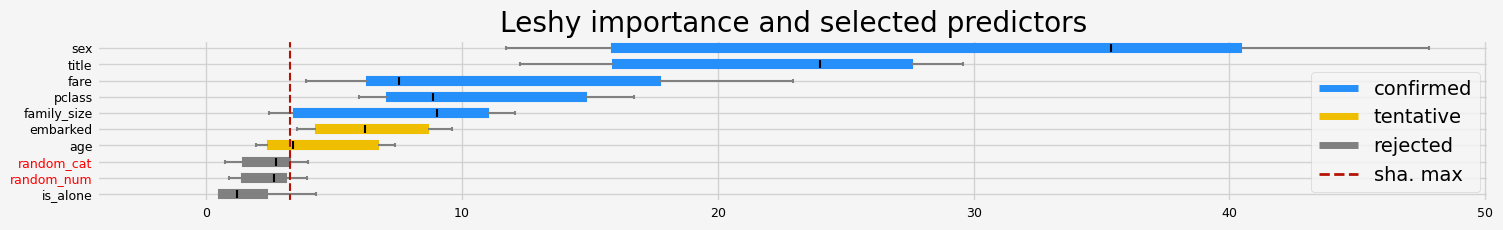

==================== Leshy - testing:            LGBMClassifier for var.imp: fastshap        ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	6
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:02.30
['pclass' 'sex' 'embarked' 'title' 'family_size' 'fare']


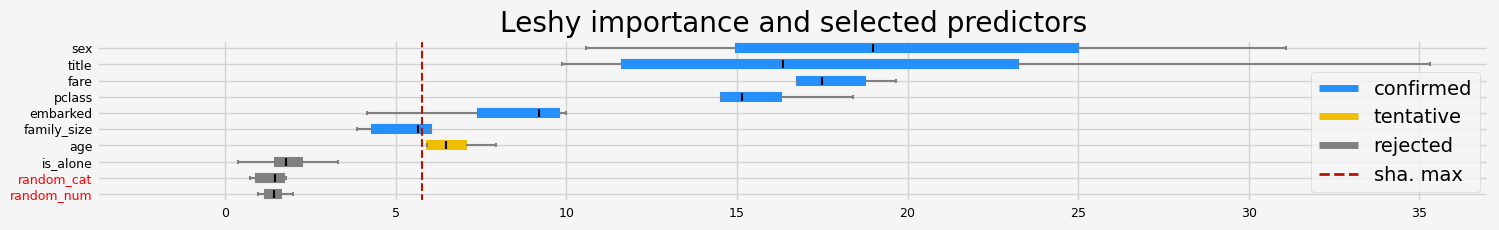

==================== Leshy - testing:            LGBMClassifier for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	4
Rejected: 	2
All relevant predictors selected in 00:00:06.88
['pclass' 'sex' 'title' 'family_size']


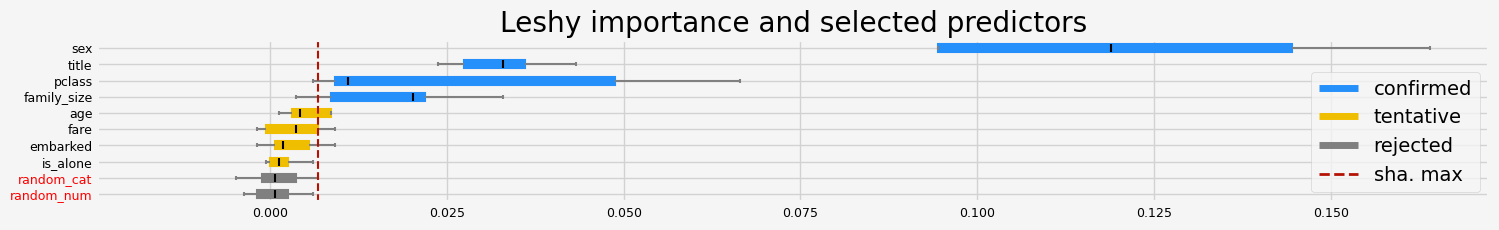

==================== Leshy - testing:            LGBMClassifier for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	1
Rejected: 	9
All relevant predictors selected in 00:00:01.60
[]


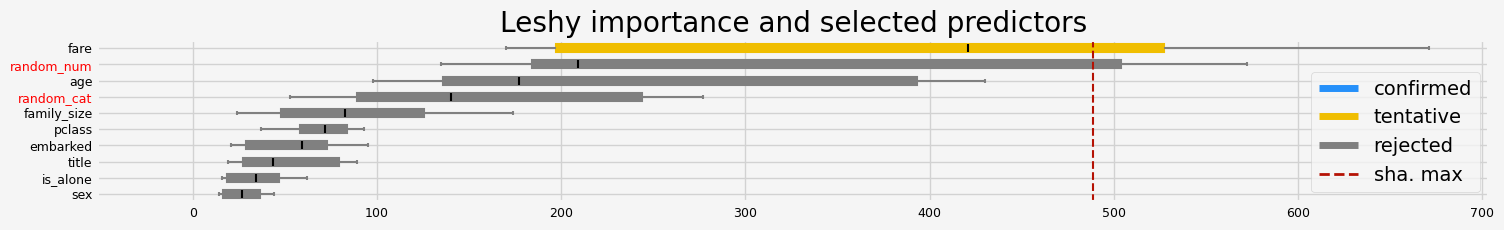

==================== Leshy - testing:             XGBClassifier for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:04.02
['pclass' 'sex' 'age' 'fare']


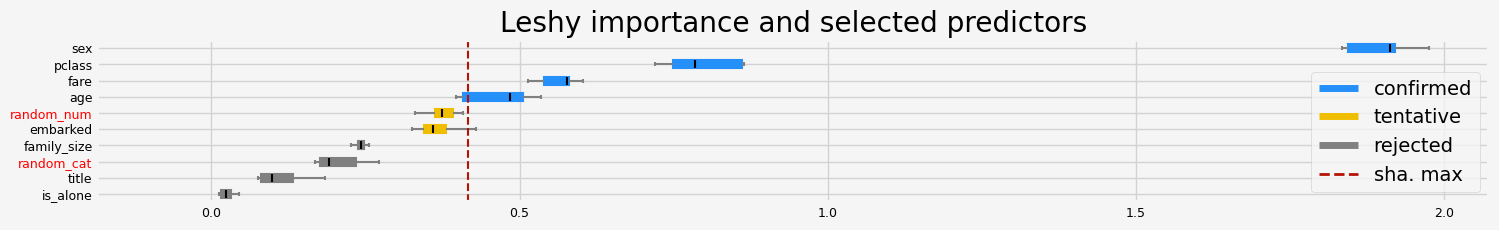

==================== Leshy - testing:             XGBClassifier for var.imp: fastshap        ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Exception: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was -4.916668, while the model output was -5.572705. If this difference is acceptable you can set check_additivity=False to disable this check.

In [23]:
models = [
    RandomForestClassifier(n_jobs=4, oob_score=True),
    CatBoostClassifier(random_state=42, verbose=0),
    LGBMClassifier(random_state=42, verbose=-1),
    LightForestClassifier(n_feat=X.shape[1]),
    XGBClassifier(random_state=42, verbosity=0, eval_metric="logloss"),
]

feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42
)

if __name__ == "__main__":
    # classification
    titanic = load_data(name="Titanic")
    X, y = titanic.data, titanic.target.cat.codes
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

In [24]:
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from fasttreeshap import TreeExplainer as FastTreeExplainer

X, y = make_classification(
    n_samples=1000, n_features=10, n_informative=8, random_state=8
)
model = XGBClassifier()
model.fit(X, y)
explainer = FastTreeExplainer(
    model, algorithm="auto", shortcut=False, feature_perturbation="tree_path_dependent"
)
shap_matrix = explainer.shap_values(X)

Exception: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 4.292476, while the model output was 4.248128. If this difference is acceptable you can set check_additivity=False to disable this check.

the fasttreeshap implementation doesn't work correctly with xgboost, I created an issue

### Testing GrootCV

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'fare']


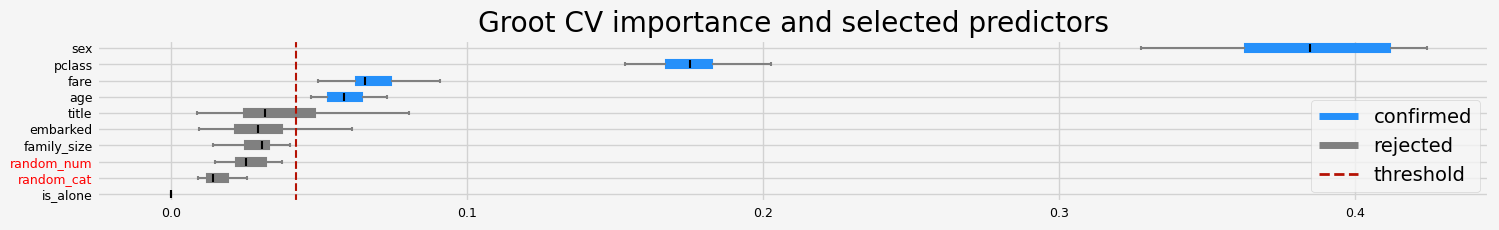

In [25]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective="binary"):
    feat_selector = arfsgroot.GrootCV(
        objective=objective, cutoff=1, n_folds=5, n_iter=5
    )
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.get_feature_names_out())
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match="random")
    plt.show()
    gc.enable()
    del feat_selector
    gc.collect()


if __name__ == "__main__":
    # classification
    titanic = load_data(name="Titanic")
    X, y = titanic.data, titanic.target
    y = y.astype(int)
    cat_f = titanic.categorical
    testing_estimators(X=X, y=y, objective="binary")

This confirms that the native (gini/gain) feature importance are biased and not the best to assess the real feature importance.

### Testing BoostAGroota

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


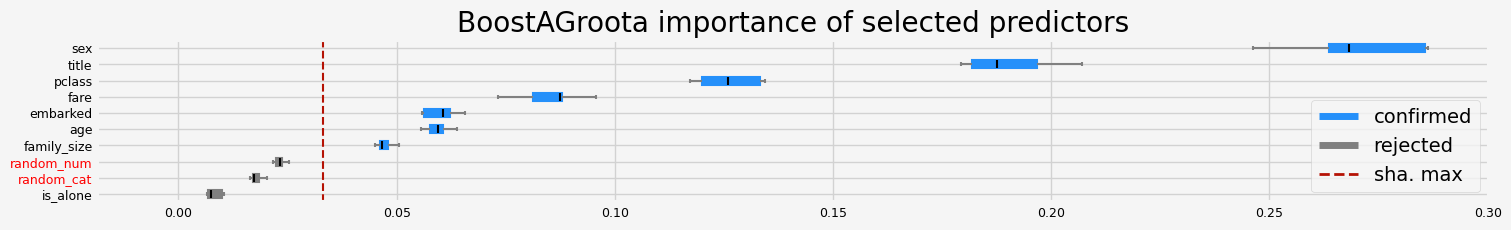

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: fastshap        ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


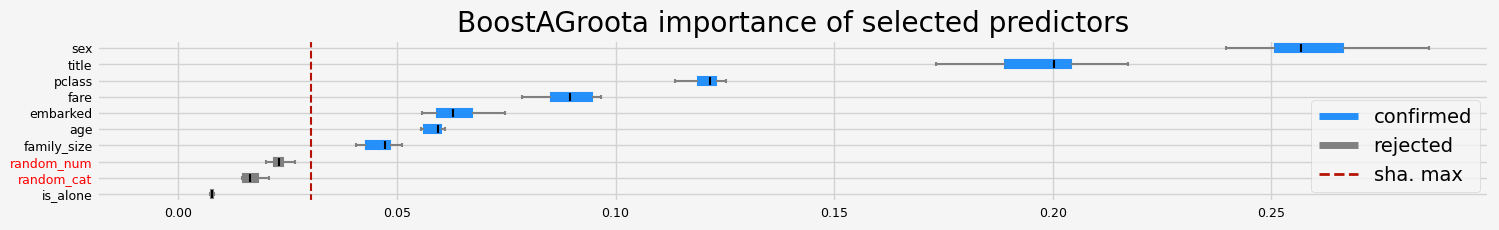

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'age' 'family_size']


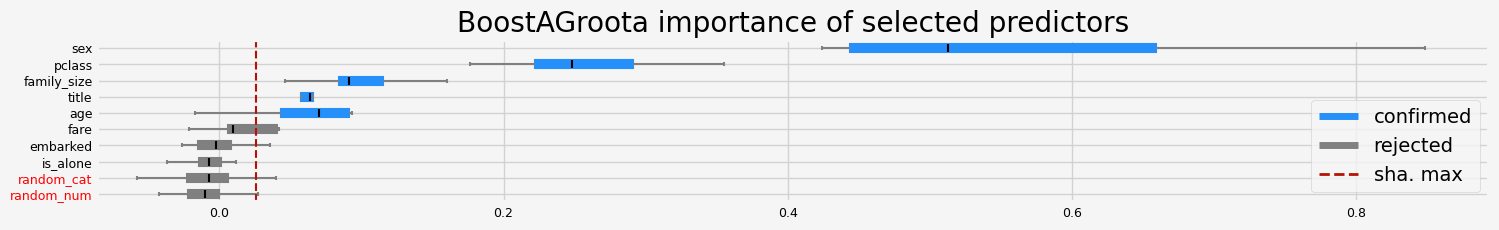

==================== BoostAGroota - testing:    RandomForestClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['sex' 'title' 'age' 'fare' 'random_num']


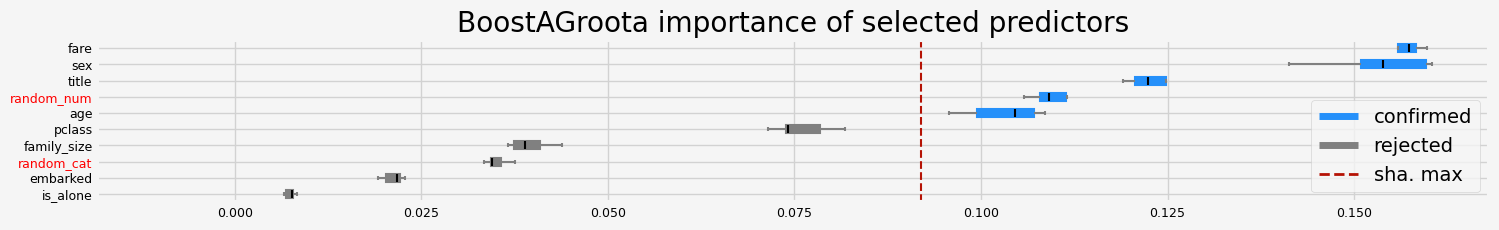

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


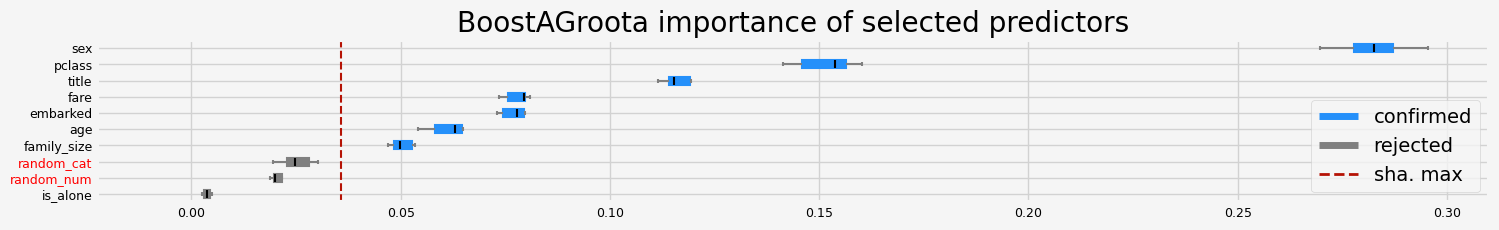

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: fastshap        ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


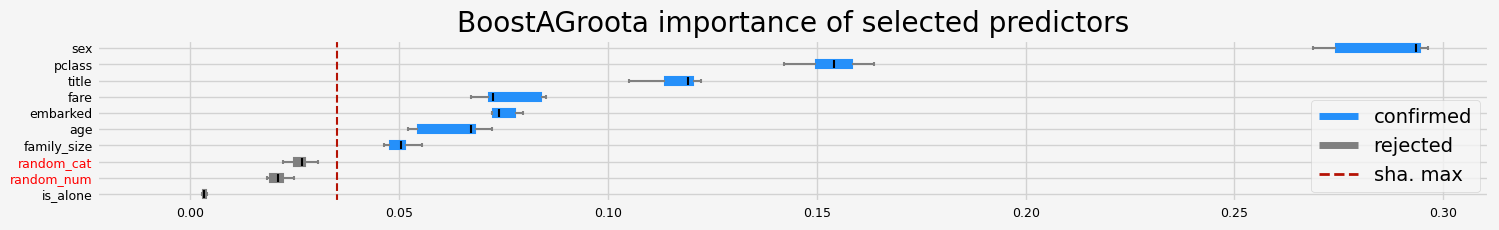

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'age' 'family_size']


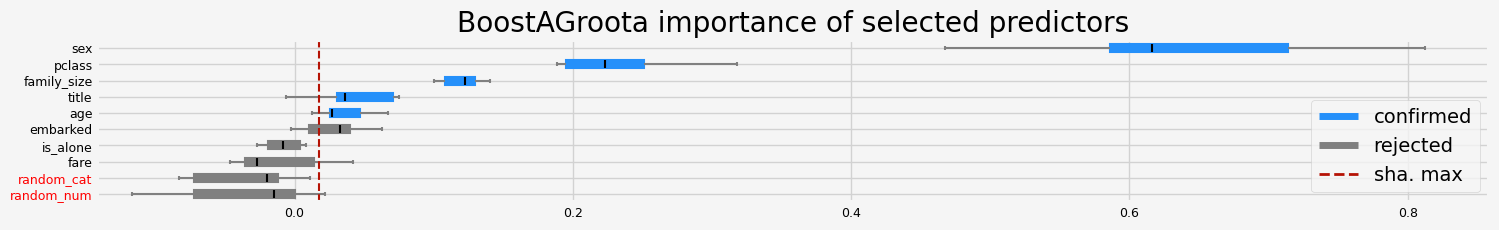

==================== BoostAGroota - testing:        CatBoostClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'age' 'fare' 'random_num']


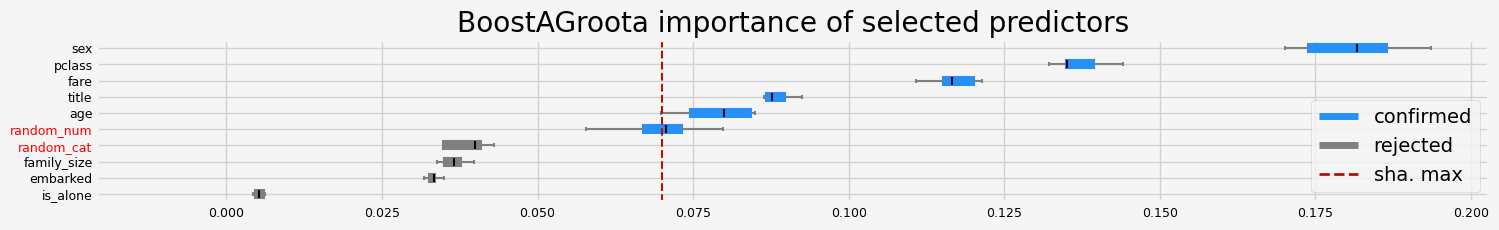

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'fare']


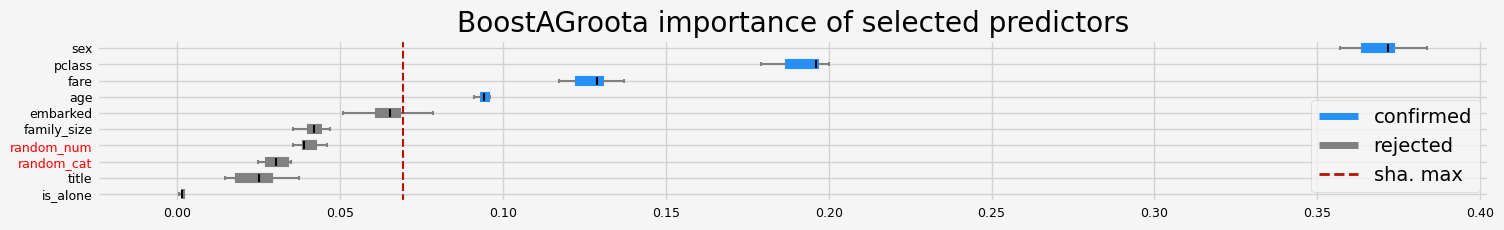

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: fastshap        ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'fare']


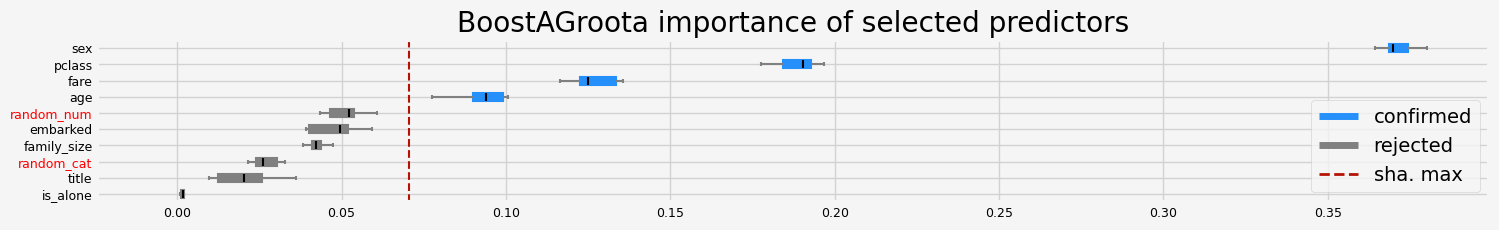

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'family_size' 'fare']


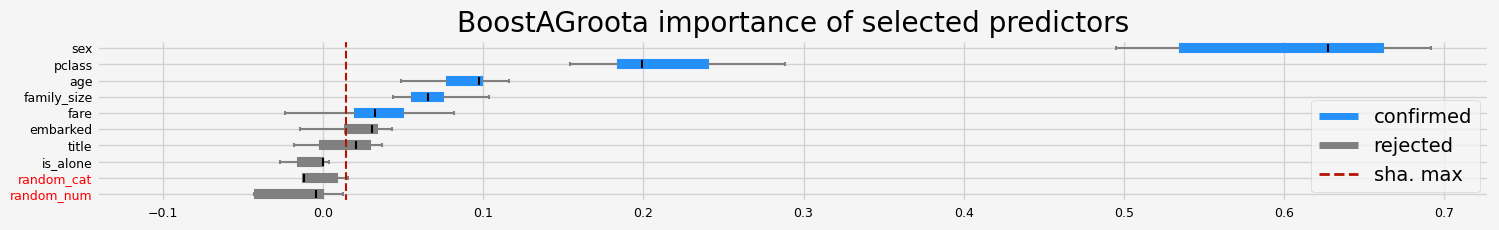

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['fare' 'random_num']


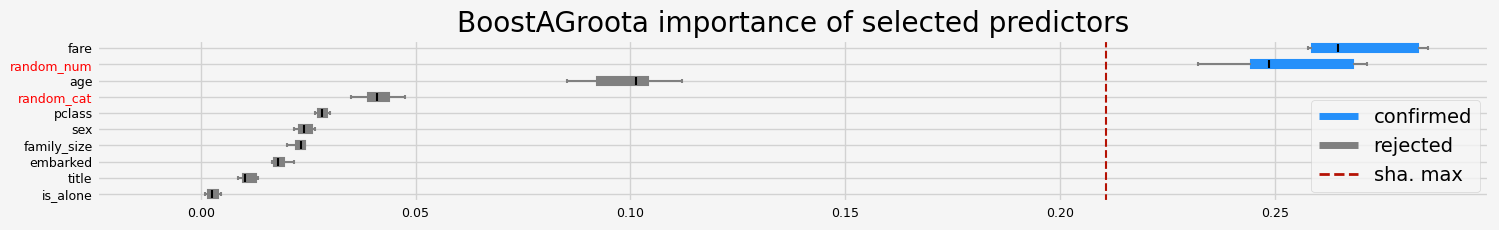

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'family_size']


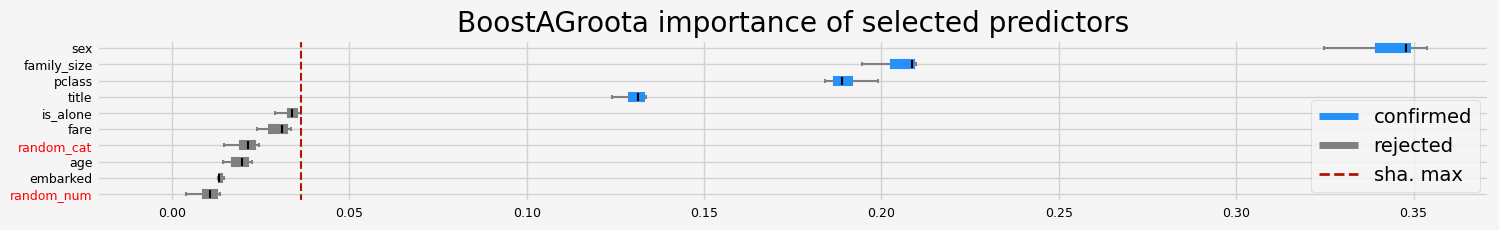

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: fastshap        ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'fare']


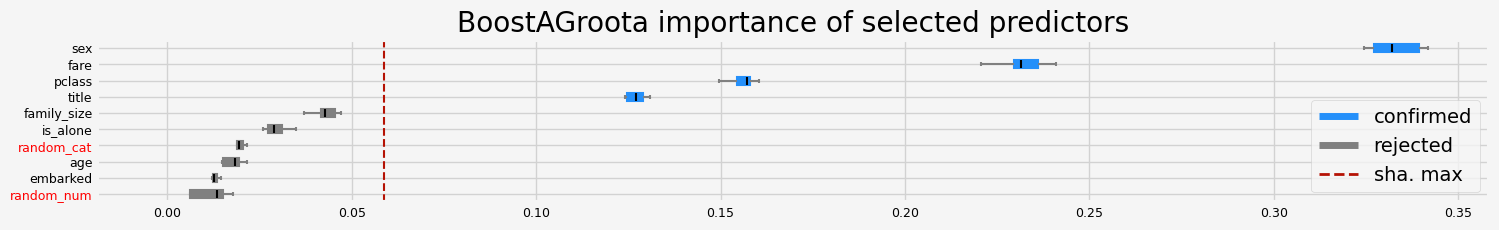

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'title' 'fare']


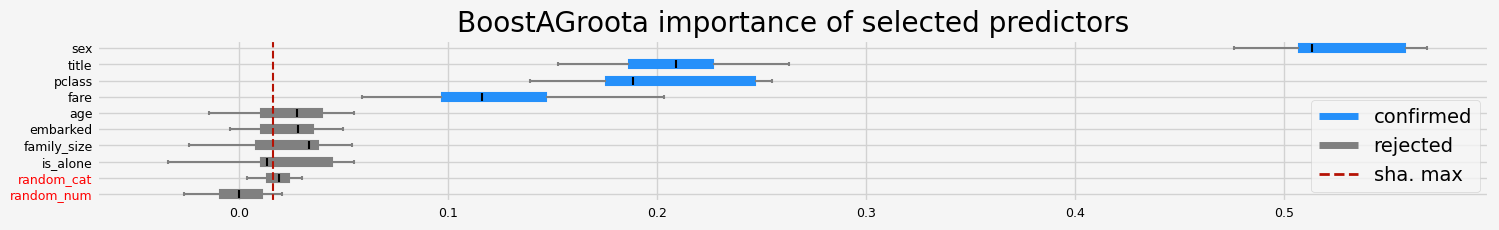

==================== BoostAGroota - testing:            LGBMClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

[]


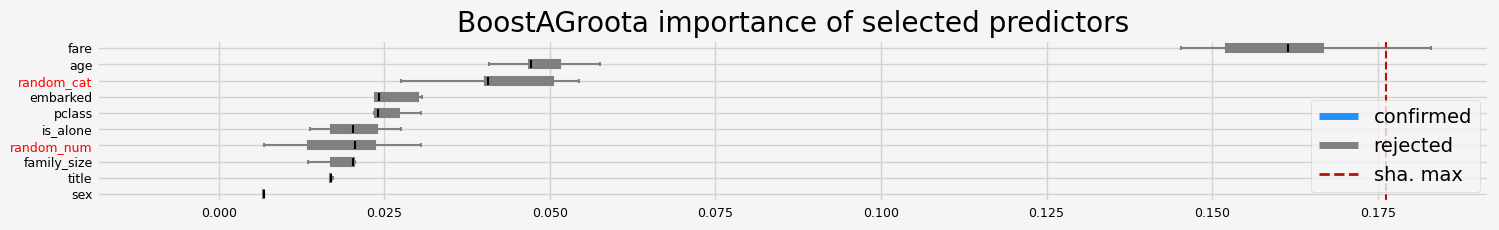

==================== BoostAGroota - testing:             XGBClassifier for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'fare' 'random_num']


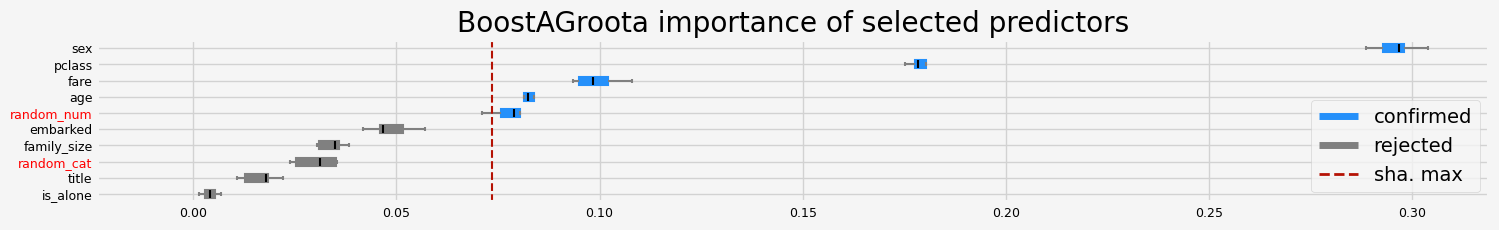

==================== BoostAGroota - testing:             XGBClassifier for var.imp: fastshap        ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'fare' 'random_num']


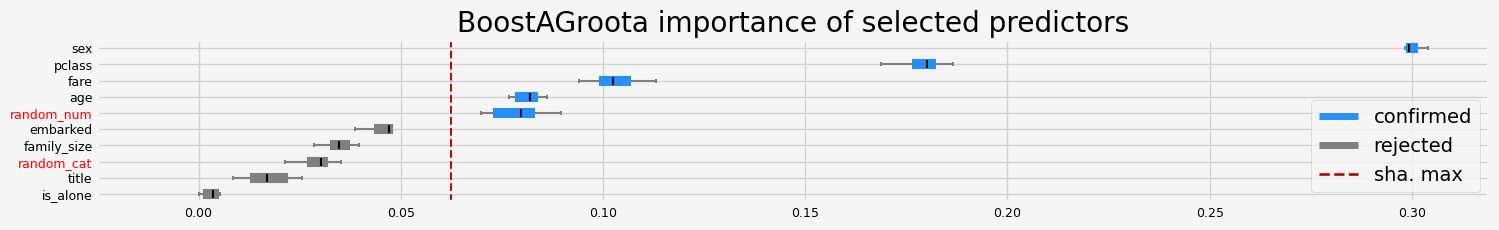

==================== BoostAGroota - testing:             XGBClassifier for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'age' 'family_size' 'fare']


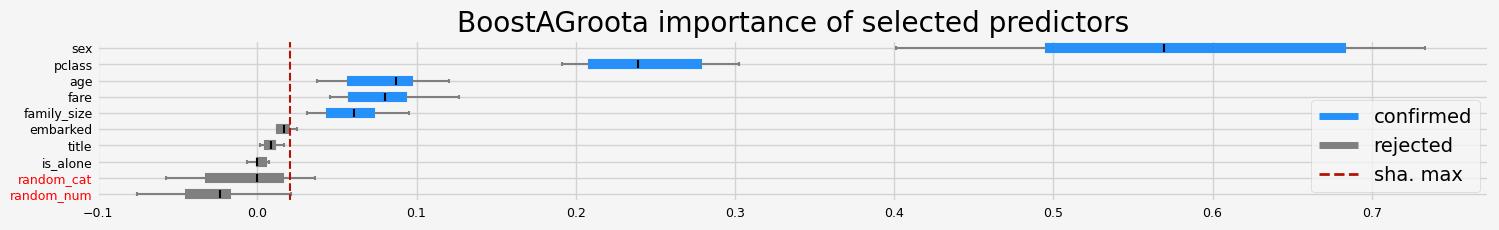

==================== BoostAGroota - testing:             XGBClassifier for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['pclass' 'sex' 'embarked' 'title' 'age' 'family_size' 'fare']


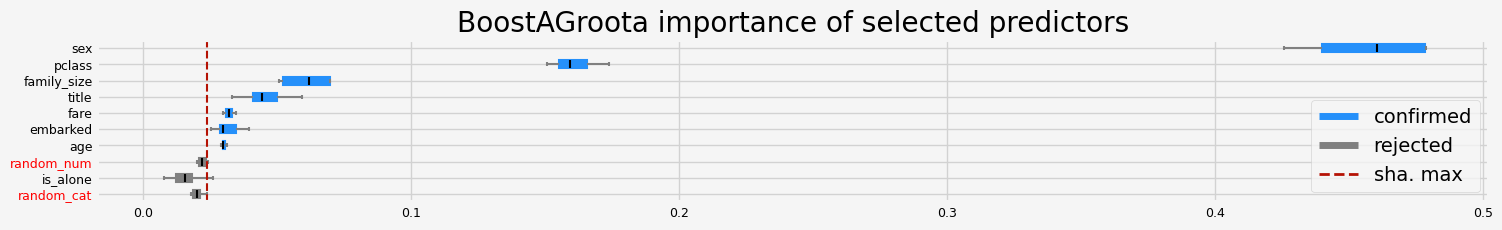

In [26]:
models = [
    RandomForestClassifier(n_jobs=4, oob_score=True),
    CatBoostClassifier(random_state=42, verbose=0),
    LGBMClassifier(random_state=42, verbose=-1),
    LightForestClassifier(n_feat=X.shape[1]),
    XGBClassifier(random_state=42, verbosity=0),
]

feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1.25, iters=10, max_rounds=10, delta=0.1
)

if __name__ == "__main__":
    # classification
    titanic = load_data(name="Titanic")
    X, y = titanic.data, titanic.target
    y = y.astype(int)
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

### comparing to BorutaShap

In [27]:
from BorutaShap import BorutaShap
from arfs.preprocessing import OrdinalEncoderPandas

model = LGBMClassifier(random_state=42, verbose=-1, n_estimators=10)
X_encoded = OrdinalEncoderPandas().fit_transform(X=X)
Feature_Selector = BorutaShap(
    model=model, importance_measure="shap", classification=True
)

Feature_Selector.fit(X=X_encoded, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
Feature_Selector.plot(X_size=12, figsize=(8, 6), y_scale="log", which_features="all")

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	5
All relevant predictors selected in 00:00:05.05
['pclass' 'sex' 'embarked' 'age' 'fare']


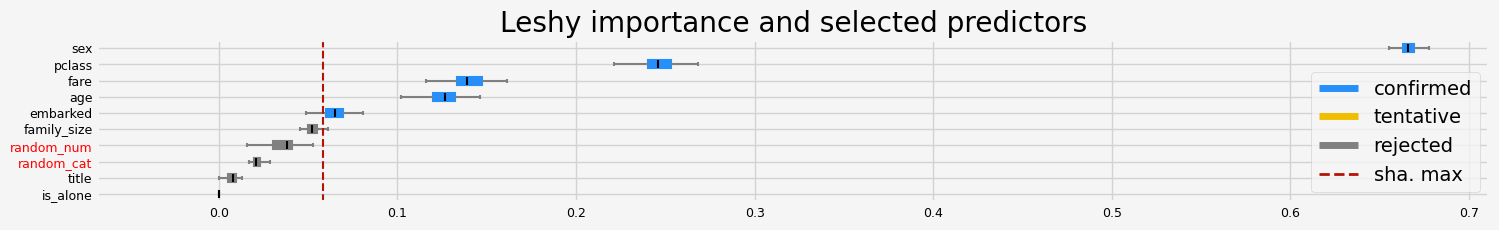

In [28]:
# Leshy
from arfs.preprocessing import OrdinalEncoderPandas

model = LGBMClassifier(random_state=42, verbose=-1, n_estimators=10)
X_encoded = OrdinalEncoderPandas().fit_transform(X=X)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=10, verbose=1, max_iter=100, random_state=42, importance="shap"
)
feat_selector.fit(X_encoded, y, sample_weight=None)
print(feat_selector.get_feature_names_out())
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()